### Modis Download and Processing
Script designed to process Modis images and save them one by one.

1. Find vtiles/htiles/dates for each data point
2. define windows around them, cut image
3. save images 

Potentially intended to offload eventually to azure vms

__________________________
Currently only compiled for train labels

In [1]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
from osgeo import gdal
from osgeo import gdalconst

import tempfile
import wget
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis_snow')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

#### Modis/azure helpers


In [2]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

In [3]:
def images_downloader(tiles, centroids, out_dataset, prod_name):
    """"""
    cell_ids = []
    i = 0
    for date_tile in tqdm(tiles.keys()):
        print("\n",i)

        date = date_tile[0]
        daynum = daynum_gen(date)   
        tile_num = (date_tile[1],date_tile[2])

        folder = prod_name + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum


        # Find all HDF files from this tile on this day
        filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
        print('Found {} matching file(s):'.format(len(filenames)))
        for fn in filenames:
            print(fn)
        file_root = filenames.copy()
        
        if len(file_root) > 1: #images may come in multiples
            print("multiple files found: ", len(file_root))
            blob_name1 = filenames[0]
            blob_name2 = filenames[1]
            
            # Download to a temporary file
            url1 = modis_blob_root + blob_name1
            url2 = modis_blob_root + blob_name2

            filename = os.path.join(temp_dir,blob_name1.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url1,filename)
                
            filename = os.path.join(temp_dir,blob_name2.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url2,filename)
            rds1 = rxr.open_rasterio(filename)
            rds2 = rxr.open_rasterio(filename)
            
            #find highest quality image
            rds1_quality = ((rds1.NDSI_Snow_Cover_Basic_QA.values >0) | (rds1.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            rds2_quality = ((rds2.NDSI_Snow_Cover_Basic_QA.values >0) | (rds2.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            
            rds = rds1 if rds1_quality >= rds2_quality else rds2 
                
        else:
            # Work with the first returned URL
            file_found = False
            breaker = 1
            while not file_found and breaker <= 5:
                try:
                    blob_name = filenames[0]
                    file_found = True
                except IndexError:
                    print("No file found: tile {} date {}".format(tile_num,daynum))
                    date -= timedelta(days=1)
                    daynum = daynum_gen(date) 

                    breaker +=1 
                    print("trying:", daynum)
            if breaker == 5:
                raise ValueError("Image", tile_num, daynum, "not found")


            # Download to a temporary file
            url = modis_blob_root + blob_name
            filename = os.path.join(temp_dir,blob_name.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url,filename)

            rds = rxr.open_rasterio(filename)

        #####reproject#####
        image = rds.rio.reproject(dst_crs="EPSG:4326")

#         #rewrite missing values for saving
#         image = image.where(image != 255, other = 32767) 

        for var in image.data_vars:
            image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 

        #####create blocks around centroids#####    
        cells = tiles[date_tile]
        for cell in cells:
            center = centroids[cell]

            x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
            y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

            #subset 21x21 square
            xmin, xmax = x_idx -10 , x_idx + 11 
            ymin, ymax = y_idx -10 , y_idx + 11

            sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

            out_dataset[i] = sub_image.squeeze().to_array().to_numpy()
            cell_ids.append((cell, daynum)) 

            i+=1
        
        
        
    return cell_ids, out_dataset


Ingest training + testing geodata and timestamps

Note: paths are currently absolute, but happy to make them work on both machines

In [4]:
path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))

18130


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [5]:
centroids = {} #cellid : centroid

for cell in range(len(gj['features'])):
    assert len(gj['features'][cell]['geometry']['coordinates'][0]) == 5 #coordinates have repeat on fifth, make sure this is universal
    
    cell_id =gj['features'][cell]['properties']['cell_id']
    centroid = list(np.mean(
        gj['features'][cell]['geometry']['coordinates'][0][0:4],
        axis = 0)) #lazy centroid calculation
    centroids[cell_id] = centroid

1. Ingest training, testing, submission datasets
2. Find what tiles (time, h,v) each image are stored in
3. store by cell_id, recall later for centroids

In [6]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
test =pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
submission = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/submission_format.csv")
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [7]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_y.shape[0]):
    dates[train_y.iloc[i,0]] =list(
        train_y.iloc[i,1:][~train_y.iloc[i,:].isnull()].index)#cell_id : [dates]


Compile overlapping tiles

In [8]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in tqdm(dates.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

  0%|          | 0/10878 [00:00<?, ?it/s]

total squares: 91490


## Download relevant images

Process and save smaller images one by one

Delete after cutting up larger image

In [9]:
# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

Load Terra images

In [11]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids, dataset_t, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesT.npy"
np.save(output_path,dataset_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1120 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/05/2018116/MOD10A1.A2018116.h08v05.006.2018118031402.hdf

 1468
Found 1 matching file(s):
MOD10A1/08/05/2019075/MOD10A1.A2019075.h08v05.006.2019077031831.hdf

 2937
Found 1 matching file(s):
MOD10A1/08/05/2019108/MOD10A1.A2019108.h08v05.006.2019110033147.hdf

 4406
Found 1 matching file(s):
MOD10A1/08/05/2019118/MOD10A1.A2019118.h08v05.006.2019120033847.hdf

 5875
Found 1 matching file(s):
MOD10A1/08/05/2019159/MOD10A1.A2019159.h08v05.006.2019161025247.hdf

 6740
Found 1 matching file(s):
MOD10A1/09/05/2016094/MOD10A1.A2016094.h09v05.006.2016104070530.hdf

 7910
Found 1 matching file(s):
MOD10A1/08/05/2018063/MOD10A1.A2018063.h08v05.006.2018065091856.hdf

 8503
Found 1 matching file(s):
MOD10A1/08/05/2018112/MOD10A1.A2018112.h08v05.006.2018114031316.hdf

 9110
Found 1 matching file(s):
MOD10A1/08/05/2018152/MOD10A1.A2018152.h08v05.006.2018154033710.hdf

 10111
Found 1 matching file(s):
MOD10A1/08/05/2019074/MOD10A1.A2019074.h08v05.006.2019076031


 33437
Found 1 matching file(s):
MOD10A1/08/04/2014119/MOD10A1.A2014119.h08v04.006.2016170141445.hdf

 33443
Found 1 matching file(s):
MOD10A1/08/04/2014126/MOD10A1.A2014126.h08v04.006.2016170144515.hdf

 33449
Found 1 matching file(s):
MOD10A1/08/04/2014133/MOD10A1.A2014133.h08v04.006.2016170160349.hdf

 33455
Found 1 matching file(s):
MOD10A1/08/04/2014140/MOD10A1.A2014140.h08v04.006.2016170044759.hdf

 33461
Found 1 matching file(s):
MOD10A1/08/04/2014147/MOD10A1.A2014147.h08v04.006.2016170050145.hdf

 33467
Found 1 matching file(s):
MOD10A1/08/04/2014154/MOD10A1.A2014154.h08v04.006.2016170033117.hdf

 33473
Found 1 matching file(s):
MOD10A1/08/04/2014161/MOD10A1.A2014161.h08v04.006.2016170071247.hdf

 33479
Found 1 matching file(s):
MOD10A1/08/04/2014168/MOD10A1.A2014168.h08v04.006.2016170213654.hdf

 33485
Found 1 matching file(s):
MOD10A1/08/04/2014175/MOD10A1.A2014175.h08v04.006.2016170192519.hdf

 33491
Found 1 matching file(s):
MOD10A1/08/04/2014336/MOD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MOD10A1/08/04/2017094/MOD10A1.A2017094.h08v04.006.2017096053335.hdf

 33949
Found 1 matching file(s):
MOD10A1/08/04/2017101/MOD10A1.A2017101.h08v04.006.2017103033744.hdf

 33956
Found 1 matching file(s):
MOD10A1/08/04/2017108/MOD10A1.A2017108.h08v04.006.2017110030801.hdf

 33963
Found 1 matching file(s):
MOD10A1/08/04/2017115/MOD10A1.A2017115.h08v04.006.2017117025933.hdf

 33970
Found 1 matching file(s):
MOD10A1/08/04/2017122/MOD10A1.A2017122.h08v04.006.2017124031701.hdf

 33977
Found 1 matching file(s):
MOD10A1/08/04/2017129/MOD10A1.A2017129.h08v04.006.2017137214927.hdf

 33983
Found 1 matching file(s):
MOD10A1/08/04/2017136/MOD10A1.A2017136.h08v04.006.2017138030804.hdf

 33989
Found 1 matching file(s):
MOD10A1/08/04/2017143/MOD10A1.A2017143.h08v04.006.2017145031639.hdf

 33994
Found 1 matching file(s):
MOD10A1/08/04/2017150/MOD10A1.A2017150.h08v04.006.2017152031055.hdf

 33999
Found 1 matching file(s):
MOD10A1/08/04/2017157/MOD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MOD10A1/08/05/2016117/MOD10A1.A2016117.h08v05.006.2016119065405.hdf

 37292
Found 1 matching file(s):
MOD10A1/08/05/2016130/MOD10A1.A2016130.h08v05.006.2016132074011.hdf

 38019
Found 1 matching file(s):
MOD10A1/08/05/2017029/MOD10A1.A2017029.h08v05.006.2017032012323.hdf

 38726
Found 1 matching file(s):
MOD10A1/08/05/2018148/MOD10A1.A2018148.h08v05.006.2018150042246.hdf

 39433
Found 1 matching file(s):
MOD10A1/08/05/2019107/MOD10A1.A2019107.h08v05.006.2019109032744.hdf

 40424
Found 1 matching file(s):
MOD10A1/08/05/2019123/MOD10A1.A2019123.h08v05.006.2019125234149.hdf

 41133
Found 1 matching file(s):
MOD10A1/08/05/2019164/MOD10A1.A2019164.h08v05.006.2019166033705.hdf

 41842
Found 1 matching file(s):
MOD10A1/09/05/2018089/MOD10A1.A2018089.h09v05.006.2018093185834.hdf

 42223
Found 1 matching file(s):
MOD10A1/09/05/2019098/MOD10A1.A2019098.h09v05.006.2019100033234.hdf

 42522
Found 1 matching file(s):
MOD10A1/09/05/2019160/MOD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MOD10A1/08/05/2015020/MOD10A1.A2015020.h08v05.006.2016173060803.hdf

 48795
Found 1 matching file(s):
MOD10A1/08/05/2015027/MOD10A1.A2015027.h08v05.006.2016173060920.hdf

 48826
Found 1 matching file(s):
MOD10A1/08/05/2015034/MOD10A1.A2015034.h08v05.006.2016173061014.hdf

 48857
Found 1 matching file(s):
MOD10A1/08/05/2015041/MOD10A1.A2015041.h08v05.006.2016173061131.hdf

 48888
Found 1 matching file(s):
MOD10A1/08/05/2015048/MOD10A1.A2015048.h08v05.006.2016173234839.hdf

 48919
Found 1 matching file(s):
MOD10A1/08/05/2015055/MOD10A1.A2015055.h08v05.006.2016174011608.hdf

 48950
Found 1 matching file(s):
MOD10A1/08/05/2015062/MOD10A1.A2015062.h08v05.006.2016173234221.hdf

 48980
Found 1 matching file(s):
MOD10A1/08/05/2015069/MOD10A1.A2015069.h08v05.006.2016173140448.hdf

 49011
Found 1 matching file(s):
MOD10A1/08/05/2015076/MOD10A1.A2015076.h08v05.006.2016173140325.hdf

 49042
Found 1 matching file(s):
MOD10A1/08/05/2015083/MOD10A1.A2015083.h08v05.00


 51107
Found 1 matching file(s):
MOD10A1/08/05/2017150/MOD10A1.A2017150.h08v05.006.2017152032856.hdf

 51135
Found 1 matching file(s):
MOD10A1/08/05/2017157/MOD10A1.A2017157.h08v05.006.2017159034556.hdf

 51163
Found 1 matching file(s):
MOD10A1/08/05/2017164/MOD10A1.A2017164.h08v05.006.2017166030123.hdf

 51191
Found 1 matching file(s):
MOD10A1/08/05/2017171/MOD10A1.A2017171.h08v05.006.2017173030919.hdf

 51218
Found 1 matching file(s):
MOD10A1/08/05/2017339/MOD10A1.A2017339.h08v05.006.2017341031007.hdf

 51247
Found 1 matching file(s):
MOD10A1/08/05/2017346/MOD10A1.A2017346.h08v05.006.2017348031129.hdf

 51276
Found 1 matching file(s):
MOD10A1/08/05/2017353/MOD10A1.A2017353.h08v05.006.2017355030231.hdf

 51305
Found 1 matching file(s):
MOD10A1/08/05/2017360/MOD10A1.A2017360.h08v05.006.2017362032454.hdf

 51334
Found 1 matching file(s):
MOD10A1/08/05/2018002/MOD10A1.A2018002.h08v05.006.2018004030713.hdf

 51363
Found 1 matching file(s):
MOD10A1/08/05/2018009/MOD10A1.A2018009.h08v05.00


 54025
Found 1 matching file(s):
MOD10A1/10/04/2013085/MOD10A1.A2013085.h10v04.006.2016139195613.hdf

 54074
Found 1 matching file(s):
MOD10A1/10/04/2013092/MOD10A1.A2013092.h10v04.006.2016139044617.hdf

 54123
Found 1 matching file(s):
MOD10A1/10/04/2013099/MOD10A1.A2013099.h10v04.006.2016139213038.hdf
100% [..........................................................................] 9987166 / 9987166
 54172
Found 1 matching file(s):
MOD10A1/10/04/2013106/MOD10A1.A2013106.h10v04.006.2016139005006.hdf
100% [..........................................................................] 9188446 / 9188446
 54221
Found 1 matching file(s):
MOD10A1/10/04/2013113/MOD10A1.A2013113.h10v04.006.2016139010155.hdf
100% [........................................................................] 10885953 / 10885953
 54270
Found 1 matching file(s):
MOD10A1/10/04/2013120/MOD10A1.A2013120.h10v04.006.2016140060719.hdf
100% [..........................................................................] 9399101 /

100% [..........................................................................] 9407294 / 9407294
 56083
Found 1 matching file(s):
MOD10A1/10/04/2014168/MOD10A1.A2014168.h10v04.006.2016170204724.hdf
100% [..........................................................................] 9214781 / 9214781
 56132
Found 1 matching file(s):
MOD10A1/10/04/2014175/MOD10A1.A2014175.h10v04.006.2016170201333.hdf
100% [..........................................................................] 9475306 / 9475306
 56181
Found 1 matching file(s):
MOD10A1/10/04/2014336/MOD10A1.A2014336.h10v04.006.2016180002535.hdf
100% [........................................................................] 11930292 / 11930292
 56230
Found 1 matching file(s):
MOD10A1/10/04/2014343/MOD10A1.A2014343.h10v04.006.2016179222725.hdf
100% [..........................................................................] 9935537 / 9935537
 56279
Found 1 matching file(s):
MOD10A1/10/04/2014350/MOD10A1.A2014350.h10v04.006.2016179230655

100% [........................................................................] 11909824 / 11909824
 58092
Found 1 matching file(s):
MOD10A1/10/04/2016026/MOD10A1.A2016026.h10v04.006.2016028091537.hdf
100% [........................................................................] 12389122 / 12389122
 58141
Found 1 matching file(s):
MOD10A1/10/04/2016033/MOD10A1.A2016033.h10v04.006.2016036011953.hdf
100% [........................................................................] 10050306 / 10050306
 58190
Found 1 matching file(s):
MOD10A1/10/04/2016040/MOD10A1.A2016040.h10v04.006.2016042071912.hdf
100% [........................................................................] 12360452 / 12360452
 58239
Found 1 matching file(s):
MOD10A1/10/04/2016047/MOD10A1.A2016047.h10v04.006.2016049071539.hdf
100% [..........................................................................] 9546415 / 9546415
 58288
Found 0 matching file(s):
No file found: tile (10, 4) date 2016054
trying: 2016053
No fil

100% [..........................................................................] 9554763 / 9554763
 60052
Found 1 matching file(s):
MOD10A1/10/04/2017094/MOD10A1.A2017094.h10v04.006.2017096053332.hdf
100% [........................................................................] 10554117 / 10554117
 60101
Found 1 matching file(s):
MOD10A1/10/04/2017101/MOD10A1.A2017101.h10v04.006.2017103031914.hdf
100% [........................................................................] 10183715 / 10183715
 60150
Found 1 matching file(s):
MOD10A1/10/04/2017108/MOD10A1.A2017108.h10v04.006.2017110030957.hdf
100% [..........................................................................] 9356327 / 9356327
 60199
Found 1 matching file(s):
MOD10A1/10/04/2017115/MOD10A1.A2017115.h10v04.006.2017117030457.hdf
100% [..........................................................................] 9128779 / 9128779
 60248
Found 1 matching file(s):
MOD10A1/10/04/2017122/MOD10A1.A2017122.h10v04.006.2017124030318

100% [..........................................................................] 9313169 / 9313169
 62032
Found 1 matching file(s):
MOD10A1/10/04/2018170/MOD10A1.A2018170.h10v04.006.2018172032026.hdf
100% [..........................................................................] 9595723 / 9595723
 62080
Found 1 matching file(s):
MOD10A1/10/04/2018177/MOD10A1.A2018177.h10v04.006.2018179032850.hdf
100% [..........................................................................] 9280333 / 9280333
 62128
Found 1 matching file(s):
MOD10A1/10/04/2018338/MOD10A1.A2018338.h10v04.006.2018340034328.hdf
100% [........................................................................] 11836104 / 11836104
 62177
Found 1 matching file(s):
MOD10A1/10/04/2018345/MOD10A1.A2018345.h10v04.006.2018347025910.hdf
100% [........................................................................] 10619592 / 10619592
 62226
Found 1 matching file(s):
MOD10A1/10/04/2018352/MOD10A1.A2018352.h10v04.006.2018354025820

100% [..........................................................................] 9471664 / 9471664
 64195
Found 1 matching file(s):
MOD10A1/09/04/2013029/MOD10A1.A2013029.h09v04.006.2016134214953.hdf
100% [..........................................................................] 7154425 / 7154425
 64283
Found 1 matching file(s):
MOD10A1/09/04/2013036/MOD10A1.A2013036.h09v04.006.2016134202913.hdf
100% [..........................................................................] 7468127 / 7468127
 64371
Found 1 matching file(s):
MOD10A1/09/04/2013043/MOD10A1.A2013043.h09v04.006.2016137170339.hdf
100% [..........................................................................] 7592698 / 7592698
 64459
Found 1 matching file(s):
MOD10A1/09/04/2013050/MOD10A1.A2013050.h09v04.006.2016137170041.hdf
100% [..........................................................................] 7916210 / 7916210
 64547
Found 1 matching file(s):
MOD10A1/09/04/2013057/MOD10A1.A2013057.h09v04.006.2016138232212

100% [..........................................................................] 7321263 / 7321263
 67803
Found 1 matching file(s):
MOD10A1/09/04/2014105/MOD10A1.A2014105.h09v04.006.2016169234831.hdf
100% [..........................................................................] 6952623 / 6952623
 67891
Found 1 matching file(s):
MOD10A1/09/04/2014112/MOD10A1.A2014112.h09v04.006.2016170140311.hdf
100% [..........................................................................] 6961913 / 6961913
 67979
Found 1 matching file(s):
MOD10A1/09/04/2014119/MOD10A1.A2014119.h09v04.006.2016170141427.hdf
100% [..........................................................................] 7482174 / 7482174
 68067
Found 1 matching file(s):
MOD10A1/09/04/2014126/MOD10A1.A2014126.h09v04.006.2016170152507.hdf
100% [..........................................................................] 7277305 / 7277305
 68155
Found 1 matching file(s):
MOD10A1/09/04/2014133/MOD10A1.A2014133.h09v04.006.2016170160400

100% [..........................................................................] 6236033 / 6236033
 71411
Found 1 matching file(s):
MOD10A1/09/04/2015181/MOD10A1.A2015181.h09v04.006.2016180192317.hdf
100% [..........................................................................] 6471842 / 6471842
 71499
Found 1 matching file(s):
MOD10A1/09/04/2015335/MOD10A1.A2015335.h09v04.006.2016182021519.hdf
100% [..........................................................................] 9153277 / 9153277
 71587
Found 1 matching file(s):
MOD10A1/09/04/2015342/MOD10A1.A2015342.h09v04.006.2016182033844.hdf
100% [..........................................................................] 6179578 / 6179578
 71675
Found 1 matching file(s):
MOD10A1/09/04/2015349/MOD10A1.A2015349.h09v04.006.2016182012527.hdf
100% [..........................................................................] 7613179 / 7613179
 71763
Found 1 matching file(s):
MOD10A1/09/04/2015356/MOD10A1.A2015356.h09v04.006.2016182005342

100% [..........................................................................] 7822086 / 7822086
 74884
Found 1 matching file(s):
MOD10A1/09/04/2017038/MOD10A1.A2017038.h09v04.006.2017040202337.hdf
100% [..........................................................................] 7285510 / 7285510
 74971
Found 1 matching file(s):
MOD10A1/09/04/2017045/MOD10A1.A2017045.h09v04.006.2017047103812.hdf
100% [..........................................................................] 9800382 / 9800382
 75058
Found 1 matching file(s):
MOD10A1/09/04/2017052/MOD10A1.A2017052.h09v04.006.2017054100801.hdf
100% [..........................................................................] 7191233 / 7191233
 75145
Found 1 matching file(s):
MOD10A1/09/04/2017059/MOD10A1.A2017059.h09v04.006.2017061191147.hdf
100% [..........................................................................] 7412484 / 7412484
 75232
Found 1 matching file(s):
MOD10A1/09/04/2017066/MOD10A1.A2017066.h09v04.006.2017068075536

100% [..........................................................................] 7265030 / 7265030
 78451
Found 1 matching file(s):
MOD10A1/09/04/2018114/MOD10A1.A2018114.h09v04.006.2018116033122.hdf
100% [..........................................................................] 7469829 / 7469829
 78537
Found 1 matching file(s):
MOD10A1/09/04/2018121/MOD10A1.A2018121.h09v04.006.2018123032633.hdf
100% [..........................................................................] 7183106 / 7183106
 78623
Found 1 matching file(s):
MOD10A1/09/04/2018128/MOD10A1.A2018128.h09v04.006.2018130032229.hdf
100% [..........................................................................] 7207758 / 7207758
 78709
Found 1 matching file(s):
MOD10A1/09/04/2018135/MOD10A1.A2018135.h09v04.006.2018149164455.hdf
100% [..........................................................................] 7129932 / 7129932
 78795
Found 1 matching file(s):
MOD10A1/09/04/2018142/MOD10A1.A2018142.h09v04.006.2018144033513

100% [..........................................................................] 8137546 / 8137546
 82008
Found 1 matching file(s):
MOD10A1/09/04/2019344/MOD10A1.A2019344.h09v04.006.2019346033051.hdf
100% [..........................................................................] 7547720 / 7547720
 82095
Found 1 matching file(s):
MOD10A1/09/04/2019351/MOD10A1.A2019351.h09v04.006.2019353025236.hdf
100% [..........................................................................] 6814466 / 6814466
 82182
Found 1 matching file(s):
MOD10A1/09/04/2019358/MOD10A1.A2019358.h09v04.006.2019360024323.hdf
100% [..........................................................................] 7162552 / 7162552
 82269
Found 1 matching file(s):
MOD10A1/09/04/2019365/MOD10A1.A2019365.h09v04.006.2020002214524.hdf
100% [..........................................................................] 6562853 / 6562853
 82356
Found 1 matching file(s):
MOD10A1/09/05/2013001/MOD10A1.A2013001.h09v05.006.2016134180847

100% [..........................................................................] 9750120 / 9750120
 83910
Found 1 matching file(s):
MOD10A1/09/05/2014049/MOD10A1.A2014049.h09v05.006.2016168232322.hdf
100% [..........................................................................] 9517676 / 9517676
 83952
Found 1 matching file(s):
MOD10A1/09/05/2014056/MOD10A1.A2014056.h09v05.006.2016169084226.hdf
100% [..........................................................................] 9325162 / 9325162
 83994
Found 1 matching file(s):
MOD10A1/09/05/2014063/MOD10A1.A2014063.h09v05.006.2016169074458.hdf
100% [..........................................................................] 9063019 / 9063019
 84036
Found 1 matching file(s):
MOD10A1/09/05/2014070/MOD10A1.A2014070.h09v05.006.2016169071157.hdf
100% [..........................................................................] 8603308 / 8603308
 84078
Found 1 matching file(s):
MOD10A1/09/05/2014077/MOD10A1.A2014077.h09v05.006.2016169070708

100% [..........................................................................] 9033250 / 9033250
 85632
Found 1 matching file(s):
MOD10A1/09/05/2015125/MOD10A1.A2015125.h09v05.006.2016175083156.hdf
100% [..........................................................................] 9172584 / 9172584
 85674
Found 1 matching file(s):
MOD10A1/09/05/2015132/MOD10A1.A2015132.h09v05.006.2016175011430.hdf
100% [..........................................................................] 9329330 / 9329330
 85716
Found 1 matching file(s):
MOD10A1/09/05/2015139/MOD10A1.A2015139.h09v05.006.2016174232430.hdf
100% [..........................................................................] 9153200 / 9153200
 85758
Found 1 matching file(s):
MOD10A1/09/05/2015146/MOD10A1.A2015146.h09v05.006.2016174235812.hdf
100% [..........................................................................] 9013938 / 9013938
 85800
Found 1 matching file(s):
MOD10A1/09/05/2015153/MOD10A1.A2015153.h09v05.006.2016175001713

100% [..........................................................................] 8631925 / 8631925
 87312
Found 1 matching file(s):
MOD10A1/09/05/2016341/MOD10A1.A2016341.h09v05.006.2016343080626.hdf
100% [..........................................................................] 9312958 / 9312958
 87355
Found 1 matching file(s):
MOD10A1/09/05/2016348/MOD10A1.A2016348.h09v05.006.2016350112304.hdf
100% [..........................................................................] 8746680 / 8746680
 87398
Found 1 matching file(s):
MOD10A1/09/05/2016355/MOD10A1.A2016355.h09v05.006.2016357132030.hdf
100% [........................................................................] 10368699 / 10368699
 87441
Found 1 matching file(s):
MOD10A1/09/05/2016362/MOD10A1.A2016362.h09v05.006.2016364102113.hdf
100% [..........................................................................] 9999989 / 9999989
 87484
Found 1 matching file(s):
MOD10A1/09/05/2017003/MOD10A1.A2017003.h09v05.006.2017006135042

100% [..........................................................................] 9783929 / 9783929
 89072
Found 1 matching file(s):
MOD10A1/09/05/2018051/MOD10A1.A2018051.h09v05.006.2018053031605.hdf
100% [..........................................................................] 9972345 / 9972345
 89115
Found 1 matching file(s):
MOD10A1/09/05/2018058/MOD10A1.A2018058.h09v05.006.2018060034854.hdf
100% [..........................................................................] 9841343 / 9841343
 89158
Found 1 matching file(s):
MOD10A1/09/05/2018065/MOD10A1.A2018065.h09v05.006.2018068184251.hdf
100% [..........................................................................] 9295545 / 9295545
 89201
Found 1 matching file(s):
MOD10A1/09/05/2018072/MOD10A1.A2018072.h09v05.006.2018074033013.hdf
100% [..........................................................................] 8738491 / 8738491
 89244
Found 1 matching file(s):
MOD10A1/09/05/2018079/MOD10A1.A2018079.h09v05.006.2018081134206

100% [..........................................................................] 9426553 / 9426553
 90835
Found 1 matching file(s):
MOD10A1/09/05/2019127/MOD10A1.A2019127.h09v05.006.2019129031545.hdf
100% [..........................................................................] 9443967 / 9443967
 90878
Found 1 matching file(s):
MOD10A1/09/05/2019134/MOD10A1.A2019134.h09v05.006.2019136030312.hdf
100% [..........................................................................] 9233378 / 9233378
 90921
Found 1 matching file(s):
MOD10A1/09/05/2019141/MOD10A1.A2019141.h09v05.006.2019143034407.hdf
100% [..........................................................................] 9128642 / 9128642
 90964
Found 1 matching file(s):
MOD10A1/09/05/2019148/MOD10A1.A2019148.h09v05.006.2019150032905.hdf
100% [..........................................................................] 8718011 / 8718011
 91007
Found 1 matching file(s):
MOD10A1/09/05/2019155/MOD10A1.A2019155.h09v05.006.2019157031917

In [ ]:
# folder = "MOD10A1/08/05/2016047"
# filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
# print('Found {} matching file(s):'.format(len(filenames)))
# for fn in filenames:
#     print(fn)
# file_root = filenames.copy()

# file_found = False
# breaker = 1
# while not file_found and breaker <= 5:
#     try:
#         blob_name = filenames[0]
#         file_found = True
#     except IndexError:
#         print("No file found: tile {} date {}".format(tile_num,daynum))
#         date -= timedelta(days=1)
#         daynum = daynum_gen(date) 

#         breaker +=1 
#         print("trying:", daynum)
# if breaker == 5:
#     raise ValueError("Image", tile_num, daynum, "not found")


# # Download to a temporary file
# url = modis_blob_root + blob_name
# filename = os.path.join(temp_dir,blob_name.replace('/','_'))
# if not os.path.isfile(filename):
#     wget.download(url,filename)

# rds = rxr.open_rasterio(filename)


Load Aqua images

In [13]:
product = 'MYD10A1' # Aqua -afternoon

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids, dataset_a = images_downloader(tiles, centroids, dataset_a, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesA.npy"
np.save(output_path,dataset_a)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1120 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MYD10A1/08/05/2018116/MYD10A1.A2018116.h08v05.006.2018118031436.hdf

 1468
Found 1 matching file(s):
MYD10A1/08/05/2019075/MYD10A1.A2019075.h08v05.006.2019079193507.hdf

 2937
Found 1 matching file(s):
MYD10A1/08/05/2019108/MYD10A1.A2019108.h08v05.006.2019110032220.hdf

 4406
Found 1 matching file(s):
MYD10A1/08/05/2019118/MYD10A1.A2019118.h08v05.006.2019120031417.hdf

 5875
Found 1 matching file(s):
MYD10A1/08/05/2019159/MYD10A1.A2019159.h08v05.006.2019161033901.hdf

 6740
Found 1 matching file(s):
MYD10A1/09/05/2016094/MYD10A1.A2016094.h09v05.006.2016096071259.hdf

 7910
Found 1 matching file(s):
MYD10A1/08/05/2018063/MYD10A1.A2018063.h08v05.006.2018065092827.hdf

 8503
Found 1 matching file(s):
MYD10A1/08/05/2018112/MYD10A1.A2018112.h08v05.006.2018114031106.hdf

 9110
Found 1 matching file(s):
MYD10A1/08/05/2018152/MYD10A1.A2018152.h08v05.006.2018154033800.hdf

 10111
Found 1 matching file(s):
MYD10A1/08/05/2019074/MYD10A1.A2019074.h08v05.006.2019076025


 33437
Found 1 matching file(s):
MYD10A1/08/04/2014119/MYD10A1.A2014119.h08v04.006.2016170160735.hdf

 33443
Found 1 matching file(s):
MYD10A1/08/04/2014126/MYD10A1.A2014126.h08v04.006.2016170151749.hdf

 33449
Found 1 matching file(s):
MYD10A1/08/04/2014133/MYD10A1.A2014133.h08v04.006.2016170180700.hdf

 33455
Found 1 matching file(s):
MYD10A1/08/04/2014140/MYD10A1.A2014140.h08v04.006.2016170055939.hdf

 33461
Found 1 matching file(s):
MYD10A1/08/04/2014147/MYD10A1.A2014147.h08v04.006.2016170041237.hdf

 33467
Found 1 matching file(s):
MYD10A1/08/04/2014154/MYD10A1.A2014154.h08v04.006.2016170044949.hdf

 33473
Found 1 matching file(s):
MYD10A1/08/04/2014161/MYD10A1.A2014161.h08v04.006.2016170082502.hdf

 33479
Found 1 matching file(s):
MYD10A1/08/04/2014168/MYD10A1.A2014168.h08v04.006.2016170220105.hdf

 33485
Found 1 matching file(s):
MYD10A1/08/04/2014175/MYD10A1.A2014175.h08v04.006.2016170195411.hdf

 33491
Found 1 matching file(s):
MYD10A1/08/04/2014336/MYD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MYD10A1/08/04/2017094/MYD10A1.A2017094.h08v04.006.2017096062319.hdf

 33949
Found 1 matching file(s):
MYD10A1/08/04/2017101/MYD10A1.A2017101.h08v04.006.2017103033907.hdf

 33956
Found 1 matching file(s):
MYD10A1/08/04/2017108/MYD10A1.A2017108.h08v04.006.2017110042804.hdf

 33963
Found 1 matching file(s):
MYD10A1/08/04/2017115/MYD10A1.A2017115.h08v04.006.2017117150038.hdf

 33970
Found 1 matching file(s):
MYD10A1/08/04/2017122/MYD10A1.A2017122.h08v04.006.2017124031523.hdf

 33977
Found 1 matching file(s):
MYD10A1/08/04/2017129/MYD10A1.A2017129.h08v04.006.2017131204254.hdf

 33983
Found 1 matching file(s):
MYD10A1/08/04/2017136/MYD10A1.A2017136.h08v04.006.2017138033623.hdf

 33989
Found 1 matching file(s):
MYD10A1/08/04/2017143/MYD10A1.A2017143.h08v04.006.2017145031438.hdf

 33994
Found 1 matching file(s):
MYD10A1/08/04/2017150/MYD10A1.A2017150.h08v04.006.2017152030429.hdf

 33999
Found 1 matching file(s):
MYD10A1/08/04/2017157/MYD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MYD10A1/08/05/2016117/MYD10A1.A2016117.h08v05.006.2016119065226.hdf

 37292
Found 1 matching file(s):
MYD10A1/08/05/2016130/MYD10A1.A2016130.h08v05.006.2016132063510.hdf

 38019
Found 1 matching file(s):
MYD10A1/08/05/2017029/MYD10A1.A2017029.h08v05.006.2017032095146.hdf

 38726
Found 1 matching file(s):
MYD10A1/08/05/2018148/MYD10A1.A2018148.h08v05.006.2018150042714.hdf

 39433
Found 1 matching file(s):
MYD10A1/08/05/2019107/MYD10A1.A2019107.h08v05.006.2019109032945.hdf

 40424
Found 1 matching file(s):
MYD10A1/08/05/2019123/MYD10A1.A2019123.h08v05.006.2019125233813.hdf

 41133
Found 1 matching file(s):
MYD10A1/08/05/2019164/MYD10A1.A2019164.h08v05.006.2019166033029.hdf

 41842
Found 1 matching file(s):
MYD10A1/09/05/2018089/MYD10A1.A2018089.h09v05.006.2018091031556.hdf

 42223
Found 1 matching file(s):
MYD10A1/09/05/2019098/MYD10A1.A2019098.h09v05.006.2019100033454.hdf

 42522
Found 1 matching file(s):
MYD10A1/09/05/2019160/MYD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MYD10A1/08/05/2015020/MYD10A1.A2015020.h08v05.006.2016173073416.hdf

 48795
Found 1 matching file(s):
MYD10A1/08/05/2015027/MYD10A1.A2015027.h08v05.006.2016173060925.hdf

 48826
Found 1 matching file(s):
MYD10A1/08/05/2015034/MYD10A1.A2015034.h08v05.006.2016173061026.hdf

 48857
Found 1 matching file(s):
MYD10A1/08/05/2015041/MYD10A1.A2015041.h08v05.006.2016173081025.hdf

 48888
Found 1 matching file(s):
MYD10A1/08/05/2015048/MYD10A1.A2015048.h08v05.006.2016174010746.hdf

 48919
Found 1 matching file(s):
MYD10A1/08/05/2015055/MYD10A1.A2015055.h08v05.006.2016174013904.hdf

 48950
Found 1 matching file(s):
MYD10A1/08/05/2015062/MYD10A1.A2015062.h08v05.006.2016174014658.hdf

 48980
Found 1 matching file(s):
MYD10A1/08/05/2015069/MYD10A1.A2015069.h08v05.006.2016173155335.hdf

 49011
Found 1 matching file(s):
MYD10A1/08/05/2015076/MYD10A1.A2015076.h08v05.006.2016173155421.hdf

 49042
Found 1 matching file(s):
MYD10A1/08/05/2015083/MYD10A1.A2015083.h08v05.00


 51163
Found 1 matching file(s):
MYD10A1/08/05/2017164/MYD10A1.A2017164.h08v05.006.2017166032218.hdf

 51191
Found 1 matching file(s):
MYD10A1/08/05/2017171/MYD10A1.A2017171.h08v05.006.2017173032330.hdf

 51218
Found 1 matching file(s):
MYD10A1/08/05/2017339/MYD10A1.A2017339.h08v05.006.2017341031150.hdf

 51247
Found 1 matching file(s):
MYD10A1/08/05/2017346/MYD10A1.A2017346.h08v05.006.2017348030936.hdf

 51276
Found 1 matching file(s):
MYD10A1/08/05/2017353/MYD10A1.A2017353.h08v05.006.2017355232832.hdf

 51305
Found 1 matching file(s):
MYD10A1/08/05/2017360/MYD10A1.A2017360.h08v05.006.2017362032317.hdf

 51334
Found 1 matching file(s):
MYD10A1/08/05/2018002/MYD10A1.A2018002.h08v05.006.2018004030619.hdf

 51363
Found 1 matching file(s):
MYD10A1/08/05/2018009/MYD10A1.A2018009.h08v05.006.2018011030723.hdf

 51392
Found 1 matching file(s):
MYD10A1/08/05/2018016/MYD10A1.A2018016.h08v05.006.2018018032325.hdf

 51421
Found 1 matching file(s):
MYD10A1/08/05/2018023/MYD10A1.A2018023.h08v05.00


 54123
Found 1 matching file(s):
MYD10A1/10/04/2013099/MYD10A1.A2013099.h10v04.006.2016139044638.hdf

 54172
Found 1 matching file(s):
MYD10A1/10/04/2013106/MYD10A1.A2013106.h10v04.006.2016139025213.hdf

 54221
Found 1 matching file(s):
MYD10A1/10/04/2013113/MYD10A1.A2013113.h10v04.006.2016139010210.hdf

 54270
Found 1 matching file(s):
MYD10A1/10/04/2013120/MYD10A1.A2013120.h10v04.006.2016139220529.hdf

 54319
Found 1 matching file(s):
MYD10A1/10/04/2013127/MYD10A1.A2013127.h10v04.006.2016140020332.hdf

 54368
Found 1 matching file(s):
MYD10A1/10/04/2013134/MYD10A1.A2013134.h10v04.006.2016142052906.hdf

 54417
Found 1 matching file(s):
MYD10A1/10/04/2013141/MYD10A1.A2013141.h10v04.006.2016142055332.hdf

 54466
Found 1 matching file(s):
MYD10A1/10/04/2013148/MYD10A1.A2013148.h10v04.006.2016142021131.hdf

 54515
Found 1 matching file(s):
MYD10A1/10/04/2013155/MYD10A1.A2013155.h10v04.006.2016143222049.hdf

 54564
Found 1 matching file(s):
MYD10A1/10/04/2013162/MYD10A1.A2013162.h10v04.00


 58092
Found 1 matching file(s):
MYD10A1/10/04/2016026/MYD10A1.A2016026.h10v04.006.2016028074338.hdf

 58141
Found 1 matching file(s):
MYD10A1/10/04/2016033/MYD10A1.A2016033.h10v04.006.2016035134713.hdf

 58190
Found 1 matching file(s):
MYD10A1/10/04/2016040/MYD10A1.A2016040.h10v04.006.2016042065140.hdf

 58239
Found 1 matching file(s):
MYD10A1/10/04/2016047/MYD10A1.A2016047.h10v04.006.2016049063537.hdf

 58288
Found 1 matching file(s):
MYD10A1/10/04/2016054/MYD10A1.A2016054.h10v04.006.2016056075708.hdf

 58337
Found 1 matching file(s):
MYD10A1/10/04/2016061/MYD10A1.A2016061.h10v04.006.2016065015920.hdf

 58386
Found 1 matching file(s):
MYD10A1/10/04/2016068/MYD10A1.A2016068.h10v04.006.2016070071805.hdf

 58435
Found 1 matching file(s):
MYD10A1/10/04/2016075/MYD10A1.A2016075.h10v04.006.2016077104231.hdf

 58484
Found 1 matching file(s):
MYD10A1/10/04/2016082/MYD10A1.A2016082.h10v04.006.2016084143524.hdf

 58533
Found 1 matching file(s):
MYD10A1/10/04/2016089/MYD10A1.A2016089.h10v04.00


 62032
Found 1 matching file(s):
MYD10A1/10/04/2018170/MYD10A1.A2018170.h10v04.006.2018172031644.hdf

 62080
Found 1 matching file(s):
MYD10A1/10/04/2018177/MYD10A1.A2018177.h10v04.006.2018179032725.hdf

 62128
Found 1 matching file(s):
MYD10A1/10/04/2018338/MYD10A1.A2018338.h10v04.006.2018340034413.hdf

 62177
Found 1 matching file(s):
MYD10A1/10/04/2018345/MYD10A1.A2018345.h10v04.006.2018347031303.hdf

 62226
Found 1 matching file(s):
MYD10A1/10/04/2018352/MYD10A1.A2018352.h10v04.006.2018355201200.hdf

 62275
Found 1 matching file(s):
MYD10A1/10/04/2018359/MYD10A1.A2018359.h10v04.006.2018361032725.hdf

 62324
Found 1 matching file(s):
MYD10A1/10/04/2019001/MYD10A1.A2019001.h10v04.006.2019003031614.hdf

 62373
Found 1 matching file(s):
MYD10A1/10/04/2019008/MYD10A1.A2019008.h10v04.006.2019010201633.hdf

 62422
Found 1 matching file(s):
MYD10A1/10/04/2019015/MYD10A1.A2019015.h10v04.006.2019017025336.hdf

 62471
Found 1 matching file(s):
MYD10A1/10/04/2019022/MYD10A1.A2019022.h10v04.00


 67715
Found 1 matching file(s):
MYD10A1/09/04/2014098/MYD10A1.A2014098.h09v04.006.2016169223610.hdf

 67803
Found 1 matching file(s):
MYD10A1/09/04/2014105/MYD10A1.A2014105.h09v04.006.2016170005117.hdf

 67891
Found 1 matching file(s):
MYD10A1/09/04/2014112/MYD10A1.A2014112.h09v04.006.2016170154538.hdf

 67979
Found 1 matching file(s):
MYD10A1/09/04/2014119/MYD10A1.A2014119.h09v04.006.2016170160808.hdf

 68067
Found 1 matching file(s):
MYD10A1/09/04/2014126/MYD10A1.A2014126.h09v04.006.2016170151822.hdf

 68155
Found 1 matching file(s):
MYD10A1/09/04/2014133/MYD10A1.A2014133.h09v04.006.2016170180658.hdf

 68243
Found 1 matching file(s):
MYD10A1/09/04/2014140/MYD10A1.A2014140.h09v04.006.2016170055938.hdf

 68331
Found 1 matching file(s):
MYD10A1/09/04/2014147/MYD10A1.A2014147.h09v04.006.2016170041439.hdf

 68419
Found 1 matching file(s):
MYD10A1/09/04/2014154/MYD10A1.A2014154.h09v04.006.2016170045032.hdf

 68507
Found 1 matching file(s):
MYD10A1/09/04/2014161/MYD10A1.A2014161.h09v04.00


 74799
Found 1 matching file(s):
MYD10A1/09/04/2017031/MYD10A1.A2017031.h09v04.006.2017040040739.hdf

 74884
Found 1 matching file(s):
MYD10A1/09/04/2017038/MYD10A1.A2017038.h09v04.006.2017040123613.hdf

 74971
Found 1 matching file(s):
MYD10A1/09/04/2017045/MYD10A1.A2017045.h09v04.006.2017047060812.hdf

 75058
Found 1 matching file(s):
MYD10A1/09/04/2017052/MYD10A1.A2017052.h09v04.006.2017054101509.hdf

 75145
Found 1 matching file(s):
MYD10A1/09/04/2017059/MYD10A1.A2017059.h09v04.006.2017061203400.hdf

 75232
Found 1 matching file(s):
MYD10A1/09/04/2017066/MYD10A1.A2017066.h09v04.006.2017070020224.hdf

 75319
Found 1 matching file(s):
MYD10A1/09/04/2017073/MYD10A1.A2017073.h09v04.006.2017075075644.hdf

 75406
Found 1 matching file(s):
MYD10A1/09/04/2017080/MYD10A1.A2017080.h09v04.006.2017082120207.hdf

 75493
Found 1 matching file(s):
MYD10A1/09/04/2017087/MYD10A1.A2017087.h09v04.006.2017089111044.hdf

 75580
Found 1 matching file(s):
MYD10A1/09/04/2017094/MYD10A1.A2017094.h09v04.00

100% [..........................................................................] 6490877 / 6490877
 80181
Found 1 matching file(s):
MYD10A1/09/04/2019043/MYD10A1.A2019043.h09v04.006.2019045034034.hdf
100% [..........................................................................] 5401273 / 5401273
 80268
Found 1 matching file(s):
MYD10A1/09/04/2019050/MYD10A1.A2019050.h09v04.006.2019052041406.hdf
100% [..........................................................................] 6009958 / 6009958
 80355
Found 1 matching file(s):
MYD10A1/09/04/2019057/MYD10A1.A2019057.h09v04.006.2019059183159.hdf
100% [..........................................................................] 6112949 / 6112949
 80442
Found 1 matching file(s):
MYD10A1/09/04/2019064/MYD10A1.A2019064.h09v04.006.2019066022914.hdf
100% [..........................................................................] 6035124 / 6035124
 80529
Found 1 matching file(s):
MYD10A1/09/04/2019071/MYD10A1.A2019071.h09v04.006.2019073032647

100% [..........................................................................] 8978373 / 8978373
 83028
Found 1 matching file(s):
MYD10A1/09/05/2013113/MYD10A1.A2013113.h09v05.006.2016139010210.hdf
100% [..........................................................................] 8582752 / 8582752
 83070
Found 1 matching file(s):
MYD10A1/09/05/2013120/MYD10A1.A2013120.h09v05.006.2016139215939.hdf
100% [..........................................................................] 9569960 / 9569960
 83112
Found 1 matching file(s):
MYD10A1/09/05/2013127/MYD10A1.A2013127.h09v05.006.2016140021354.hdf
100% [..........................................................................] 9594535 / 9594535
 83154
Found 1 matching file(s):
MYD10A1/09/05/2013134/MYD10A1.A2013134.h09v05.006.2016142053258.hdf
100% [..........................................................................] 9221726 / 9221726
 83196
Found 1 matching file(s):
MYD10A1/09/05/2013141/MYD10A1.A2013141.h09v05.006.2016142053328

100% [..........................................................................] 8635998 / 8635998
 84750
Found 1 matching file(s):
MYD10A1/09/05/2014343/MYD10A1.A2014343.h09v05.006.2016177060058.hdf
100% [..........................................................................] 8742499 / 8742499
 84792
Found 1 matching file(s):
MYD10A1/09/05/2014350/MYD10A1.A2014350.h09v05.006.2016177045011.hdf
100% [..........................................................................] 8390241 / 8390241
 84834
Found 1 matching file(s):
MYD10A1/09/05/2014357/MYD10A1.A2014357.h09v05.006.2016179184219.hdf
100% [..........................................................................] 8570395 / 8570395
 84876
Found 1 matching file(s):
MYD10A1/09/05/2014364/MYD10A1.A2014364.h09v05.006.2016179175708.hdf
100% [..........................................................................] 7636507 / 7636507
 84918
Found 1 matching file(s):
MYD10A1/09/05/2015006/MYD10A1.A2015006.h09v05.006.2016173212748

100% [........................................................................] 10958515 / 10958515
 86472
Found 1 matching file(s):
MYD10A1/09/05/2016047/MYD10A1.A2016047.h09v05.006.2016049063930.hdf
100% [..........................................................................] 9889388 / 9889388
 86514
Found 1 matching file(s):
MYD10A1/09/05/2016054/MYD10A1.A2016054.h09v05.006.2016056075601.hdf
100% [..........................................................................] 9614954 / 9614954
 86556
Found 1 matching file(s):
MYD10A1/09/05/2016061/MYD10A1.A2016061.h09v05.006.2016065015912.hdf
100% [..........................................................................] 8541794 / 8541794
 86598
Found 1 matching file(s):
MYD10A1/09/05/2016068/MYD10A1.A2016068.h09v05.006.2016070070520.hdf
100% [..........................................................................] 8599149 / 8599149
 86640
Found 1 matching file(s):
MYD10A1/09/05/2016075/MYD10A1.A2016075.h09v05.006.2016077104229

100% [..........................................................................] 9283252 / 9283252
 88215
Found 1 matching file(s):
MYD10A1/09/05/2017122/MYD10A1.A2017122.h09v05.006.2017124032155.hdf
100% [..........................................................................] 9246388 / 9246388
 88258
Found 1 matching file(s):
MYD10A1/09/05/2017129/MYD10A1.A2017129.h09v05.006.2017131204251.hdf
100% [..........................................................................] 7938004 / 7938004
 88301
Found 1 matching file(s):
MYD10A1/09/05/2017136/MYD10A1.A2017136.h09v05.006.2017138030334.hdf
100% [..........................................................................] 8586860 / 8586860
 88343
Found 1 matching file(s):
MYD10A1/09/05/2017143/MYD10A1.A2017143.h09v05.006.2017145032251.hdf
100% [..........................................................................] 8394352 / 8394352
 88385
Found 1 matching file(s):
MYD10A1/09/05/2017150/MYD10A1.A2017150.h09v05.006.2017152033937

100% [..........................................................................] 8898161 / 8898161
 89975
Found 1 matching file(s):
MYD10A1/09/05/2018352/MYD10A1.A2018352.h09v05.006.2018355201200.hdf
100% [..........................................................................] 8455720 / 8455720
 90018
Found 1 matching file(s):
MYD10A1/09/05/2018359/MYD10A1.A2018359.h09v05.006.2018361032720.hdf
100% [..........................................................................] 7648807 / 7648807
 90061
Found 1 matching file(s):
MYD10A1/09/05/2019001/MYD10A1.A2019001.h09v05.006.2019003030723.hdf
100% [..........................................................................] 8107631 / 8107631
 90104
Found 1 matching file(s):
MYD10A1/09/05/2019008/MYD10A1.A2019008.h09v05.006.2019010202548.hdf
100% [..........................................................................] 8261591 / 8261591
 90147
Found 1 matching file(s):
MYD10A1/09/05/2019015/MYD10A1.A2019015.h09v05.006.2019017025512

100% [............................................................................] 899823 / 899823
 91480
Found 1 matching file(s):
MYD10A1/08/04/2016068/MYD10A1.A2016068.h08v04.006.2016070070520.hdf
100% [............................................................................] 854777 / 854777
 91485
Found 1 matching file(s):
MYD10A1/08/04/2016075/MYD10A1.A2016075.h08v04.006.2016077104228.hdf
100% [..........................................................................] 1066605 / 1066605

### Sanity check if desired

In [51]:
def plot_image(image):
    image[image == image.max()] = image.max()/3
    image = image/image.max()
    r = image[12]; g = image[2]; b = image[1]
    
    plt.imshow(np.dstack([r,g,b]))

# plot_image(dataset[10001])

## Load and process submission images

In [14]:
#grab date/cell_id combos
dates_sub = {}

#go through all rows, grab nonnull dates_sub
for i in range(submission.shape[0]):
    dates_sub[submission.iloc[i,0]] =list(
        submission.iloc[i,1:][~submission.iloc[i,:].isnull()].index)#cell_id : [dates_sub]

In [15]:
# create dictionary tiles_sub (date, lat, lon) : [cell_ids]
counter_sub = 0 
tiles_sub = defaultdict(list)
for cell, date_list in tqdm(dates_sub.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_sub[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter_sub += 1
print("total squares:", counter_sub)    

  0%|          | 0/9066 [00:00<?, ?it/s]

total squares: 516762


Load Terra Submission Data

In [16]:
product = 'MOD10A1'

#initialize empty array
dataset_sub_t = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_t = images_downloader(tiles_sub, centroids, dataset_sub_t, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_subT.npy"
np.save(output_path,dataset_sub_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_subT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

  0%|          | 0/285 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/05/2020007/MOD10A1.A2020007.h08v05.006.2020009031114.hdf
100% [..........................................................................] 7169576 / 7169576
 6058
Found 1 matching file(s):
MOD10A1/08/05/2020014/MOD10A1.A2020014.h08v05.006.2020016203651.hdf
100% [..........................................................................] 7286739 / 7286739
 12116
Found 1 matching file(s):
MOD10A1/08/05/2020021/MOD10A1.A2020021.h08v05.006.2020023033534.hdf
100% [..........................................................................] 7190125 / 7190125
 18174
Found 1 matching file(s):
MOD10A1/08/05/2020028/MOD10A1.A2020028.h08v05.006.2020030031824.hdf
100% [..........................................................................] 7399087 / 7399087
 24232
Found 1 matching file(s):
MOD10A1/08/05/2020035/MOD10A1.A2020035.h08v05.006.2020037024957.hdf
100% [..........................................................................] 7760496 / 7760496

100% [..........................................................................] 6149743 / 6149743
 248378
Found 1 matching file(s):
MOD10A1/08/05/2021075/MOD10A1.A2021075.h08v05.006.2021077045939.hdf
100% [..........................................................................] 6612591 / 6612591
 254436
Found 1 matching file(s):
MOD10A1/08/05/2021082/MOD10A1.A2021082.h08v05.006.2021084055918.hdf
100% [..........................................................................] 6571628 / 6571628
 260494
Found 1 matching file(s):
MOD10A1/08/05/2021089/MOD10A1.A2021089.h08v05.006.2021091041837.hdf
100% [..........................................................................] 6497901 / 6497901
 266552
Found 1 matching file(s):
MOD10A1/08/05/2021096/MOD10A1.A2021096.h08v05.006.2021098031839.hdf
100% [..........................................................................] 6768166 / 6768166
 272610
Found 1 matching file(s):
MOD10A1/08/05/2021103/MOD10A1.A2021103.h08v05.006.20211050

100% [..........................................................................] 8103463 / 8103463
 416881
Found 1 matching file(s):
MOD10A1/09/05/2020182/MOD10A1.A2020182.h09v05.006.2020184031959.hdf
100% [..........................................................................] 8091244 / 8091244
 419744
Found 1 matching file(s):
MOD10A1/09/05/2020336/MOD10A1.A2020336.h09v05.006.2020338051405.hdf
100% [..........................................................................] 8878706 / 8878706
 422607
Found 1 matching file(s):
MOD10A1/09/05/2020343/MOD10A1.A2020343.h09v05.006.2020345031403.hdf
100% [..........................................................................] 8660659 / 8660659
 425470
Found 1 matching file(s):
MOD10A1/09/05/2020350/MOD10A1.A2020350.h09v05.006.2020352023509.hdf
100% [..........................................................................] 9582261 / 9582261
 428333
Found 1 matching file(s):
MOD10A1/09/05/2020357/MOD10A1.A2020357.h09v05.006.20203590

100% [..........................................................................] 1321654 / 1321654
 508560
Found 1 matching file(s):
MOD10A1/08/04/2020070/MOD10A1.A2020070.h08v04.006.2020072032410.hdf
100% [..........................................................................] 1342133 / 1342133
 508567
Found 1 matching file(s):
MOD10A1/08/04/2020077/MOD10A1.A2020077.h08v04.006.2020079033001.hdf
100% [..........................................................................] 1149620 / 1149620
 508574
Found 1 matching file(s):
MOD10A1/08/04/2020084/MOD10A1.A2020084.h08v04.006.2020086032116.hdf
100% [..........................................................................] 1268407 / 1268407
 508581
Found 1 matching file(s):
MOD10A1/08/04/2020091/MOD10A1.A2020091.h08v04.006.2020093030008.hdf
100% [..........................................................................] 1250333 / 1250333
 508588
Found 1 matching file(s):
MOD10A1/08/04/2020098/MOD10A1.A2020098.h08v04.006.20201010

100% [..........................................................................] 1018621 / 1018621
 508847
Found 1 matching file(s):
MOD10A1/08/04/2021138/MOD10A1.A2021138.h08v04.006.2021140035730.hdf
100% [..........................................................................] 1096446 / 1096446
 508854
Found 1 matching file(s):
MOD10A1/08/04/2021145/MOD10A1.A2021145.h08v04.006.2021147054004.hdf
100% [..........................................................................] 1206964 / 1206964
 508861
Found 1 matching file(s):
MOD10A1/08/04/2021152/MOD10A1.A2021152.h08v04.006.2021154034350.hdf
100% [..........................................................................] 1129141 / 1129141
 508868
Found 1 matching file(s):
MOD10A1/08/04/2021159/MOD10A1.A2021159.h08v04.006.2021161044752.hdf
100% [..........................................................................] 1239735 / 1239735
 508875
Found 1 matching file(s):
MOD10A1/08/04/2021166/MOD10A1.A2021166.h08v04.006.20211680

100% [........................................................................] 10373891 / 10373891
 510562
Found 1 matching file(s):
MOD10A1/10/04/2021026/MOD10A1.A2021026.h10v04.006.2021028033528.hdf
100% [..........................................................................] 9767685 / 9767685
 510611
Found 1 matching file(s):
MOD10A1/10/04/2021033/MOD10A1.A2021033.h10v04.006.2021035033941.hdf
100% [..........................................................................] 9755322 / 9755322
 510660
Found 1 matching file(s):
MOD10A1/10/04/2021040/MOD10A1.A2021040.h10v04.006.2021042032907.hdf
100% [........................................................................] 10307255 / 10307255
 510709
Found 1 matching file(s):
MOD10A1/10/04/2021047/MOD10A1.A2021047.h10v04.006.2021049040855.hdf
100% [..........................................................................] 9836143 / 9836143
 510758
Found 1 matching file(s):
MOD10A1/10/04/2021054/MOD10A1.A2021054.h10v04.006.20210560

100% [..........................................................................] 6683392 / 6683392
 513291
Found 1 matching file(s):
MOD10A1/09/04/2020133/MOD10A1.A2020133.h09v04.006.2020135033343.hdf
100% [..........................................................................] 6150909 / 6150909
 513380
Found 1 matching file(s):
MOD10A1/09/04/2020140/MOD10A1.A2020140.h09v04.006.2020142042034.hdf
100% [..........................................................................] 6452986 / 6452986
 513469
Found 1 matching file(s):
MOD10A1/09/04/2020147/MOD10A1.A2020147.h09v04.006.2020149033828.hdf
100% [..........................................................................] 6764353 / 6764353
 513558
Found 1 matching file(s):
MOD10A1/09/04/2020154/MOD10A1.A2020154.h09v04.006.2020156033048.hdf
100% [..........................................................................] 6670074 / 6670074
 513647
Found 1 matching file(s):
MOD10A1/09/04/2020161/MOD10A1.A2020161.h09v04.006.20201630

Load Aqua Submission Data

In [ ]:
product = 'MYD10A1'

#initialize empty array
dataset_sub_a = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_a = images_downloader(tiles_sub, centroids, dataset_sub_a, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_subA.npy"
np.save(output_path,dataset_sub_a)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_subA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

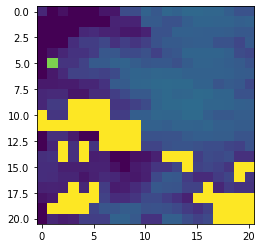

In [26]:
plt.imshow(dataset_sub_t[9000,0,:,:])